#### imports

In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

#### functions

In [79]:
def load_image(path):
    '''loads the mask image'''
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return mask

def find_center(mask):
    '''finds the center of the lesion'''
    white_pixels = np.argwhere(mask > 0)
    center_row = np.mean(white_pixels[:, 0]).astype(int)
    center_col = np.mean(white_pixels[:, 1]).astype(int)
    
    return center_row, center_col

def flip_image_centered(mask, axis):
    '''flips the image along its center axis'''
    center_row, center_col = find_center(mask)
    
    if axis == 'vertical':
        image_shifted = np.roll(mask, -center_row, axis=0)
        flipped_image = np.flipud(image_shifted)
        return np.roll(flipped_image, center_row, axis=0)
    elif axis == 'horizontal':
        image_shifted = np.roll(mask, -center_col, axis=1)
        flipped_image = np.fliplr(image_shifted)
        return np.roll(flipped_image, center_col, axis=1)
    
def compute_overlap(image1, image2):
    """compute the overlap score"""
    
    intersection = np.logical_and(image1, image2)
    union = np.logical_or(image1, image2)
    overlap = np.sum(intersection) / np.sum(union)
    
    return overlap

def symmetry_score(image):
    """compute the vertical and horizontal symmetry scores"""
    mask = load_image(image) # load the image from path
    

    vert_flipped = flip_image_centered(mask, 'vertical')
    horiz_flipped = flip_image_centered(mask, 'horizontal')
    
    vertical_symmetry_score = compute_overlap(mask, vert_flipped)
    horizontal_symmetry_score = compute_overlap(mask, horiz_flipped)
    total_score = round((vertical_symmetry_score + horizontal_symmetry_score) / 2, 4)

    return total_score

#### display images

In [80]:
def test_images(path, save_folder):
    '''plots the images to visualize our alogirhthm and save them to a folder'''
    
    mask = load_image(path) # load the image from path
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    
    center_row, center_col = find_center(mask)

    vert_flipped = flip_image_centered(mask, 'vertical')
    horiz_flipped = flip_image_centered(mask, 'horizontal')
    
    vertical_symmetry_score = compute_overlap(mask, vert_flipped)
    horizontal_symmetry_score = compute_overlap(mask, horiz_flipped)
    
    total_score = round((vertical_symmetry_score + horizontal_symmetry_score) / 2, 4)

    overlay_vert = cv2.addWeighted(mask, 0.5, vert_flipped, 0.5, 0)
    overlay_horiz = cv2.addWeighted(mask, 0.5, horiz_flipped, 0.5, 0)
    
    # check if the save folder exists, if not, create it
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    images = [mask, vert_flipped, overlay_vert, mask, horiz_flipped, overlay_horiz]
    titles = ['Original Image', 'Vertically Flipped', f'Overlay (Vertical) | score: {round(vertical_symmetry_score, 4)}',
              'Original Image', 'Horizontally Flipped', f'Overlay (Horizontal) | score: {round(horizontal_symmetry_score, 4)}']

    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axhline(center_row, color='r', linestyle='--')
        ax.axvline(center_col, color='r', linestyle='--')
        ax.set_title(titles[i])
        ax.axis('off')

    plt.suptitle(f'Symmetry score: {total_score}')
    
    plt.tight_layout()

    # save the figure to the designated save folder
    save_path = os.path.join(save_folder, f"result_{os.path.basename(path)}.png")
    plt.savefig(save_path)

#### looping over images

Image successfully saved.
Image successfully saved.
Image successfully saved.
Image successfully saved.
Image successfully saved.
Image successfully saved.
Image successfully saved.
Image successfully saved.
Image successfully saved.
Image successfully saved.
Image successfully saved.
Image successfully saved.
Image successfully saved.


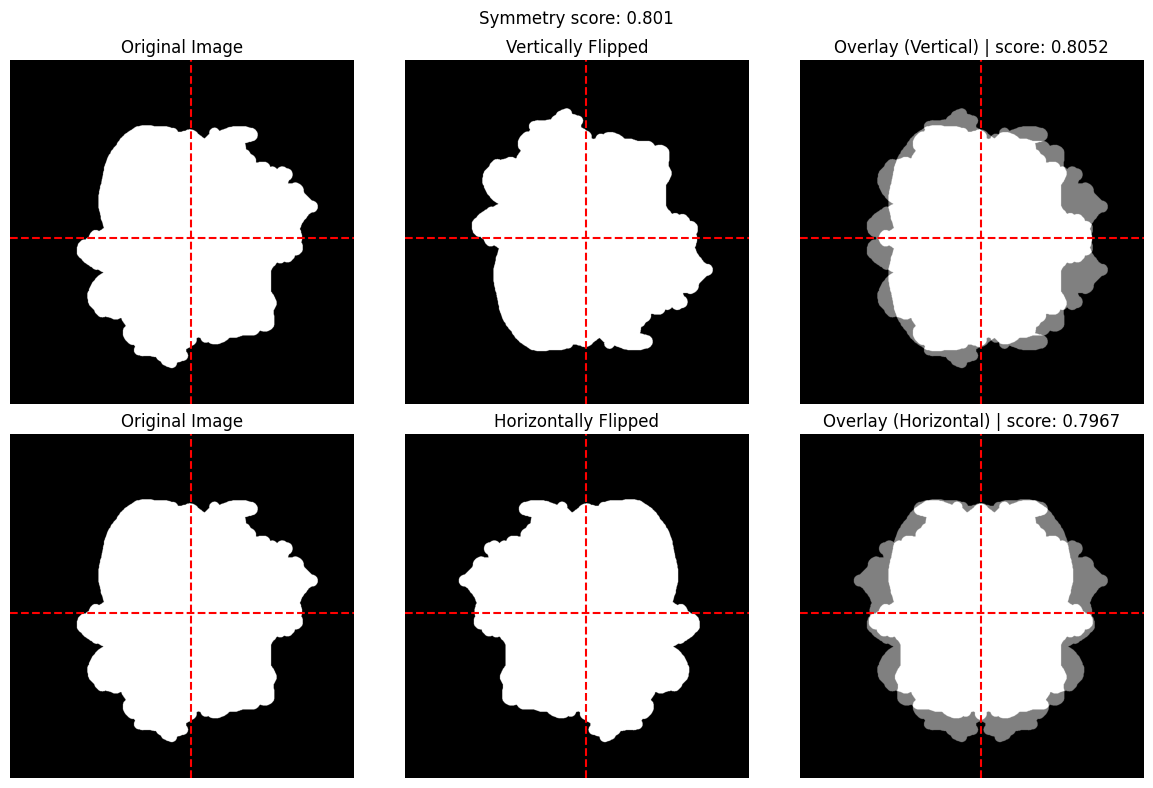

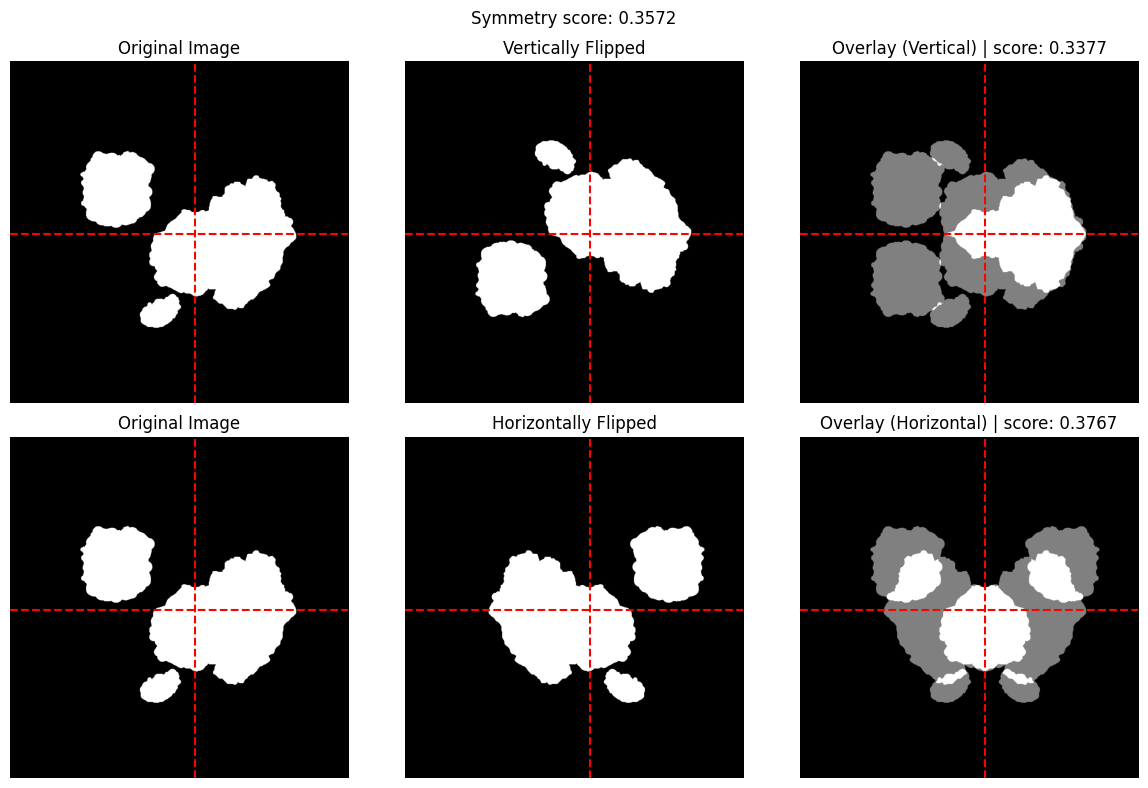

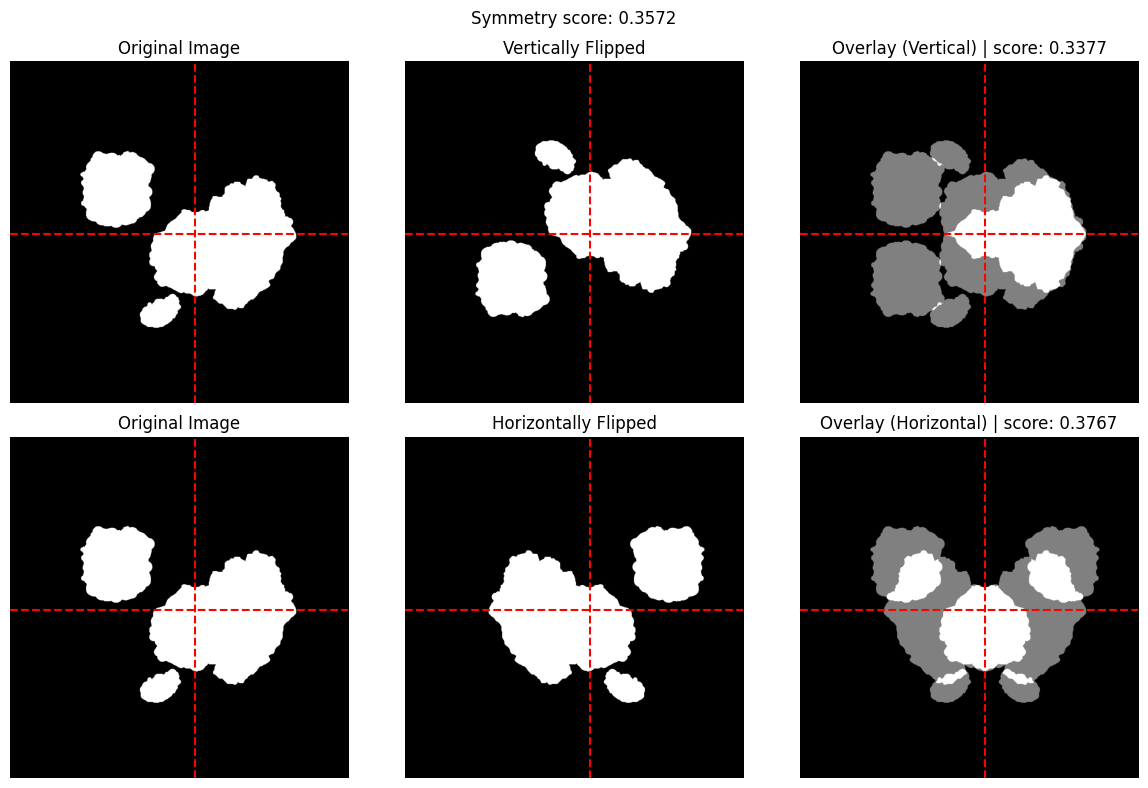

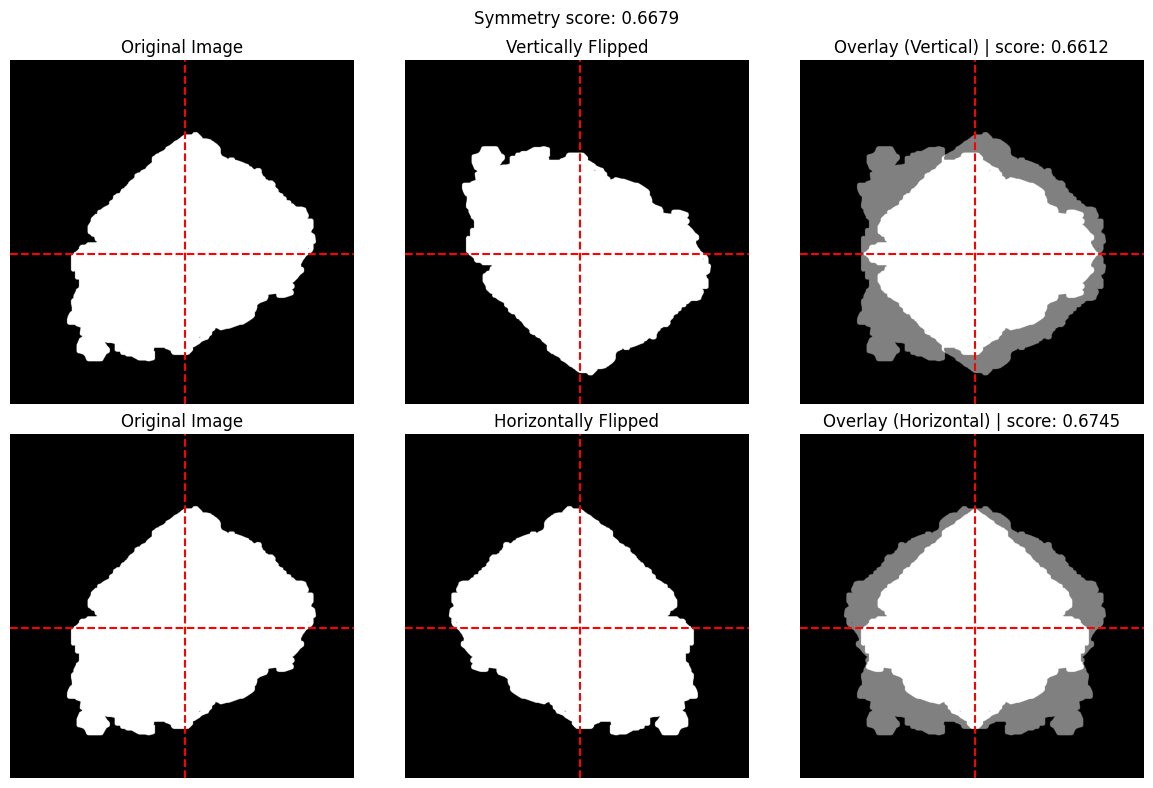

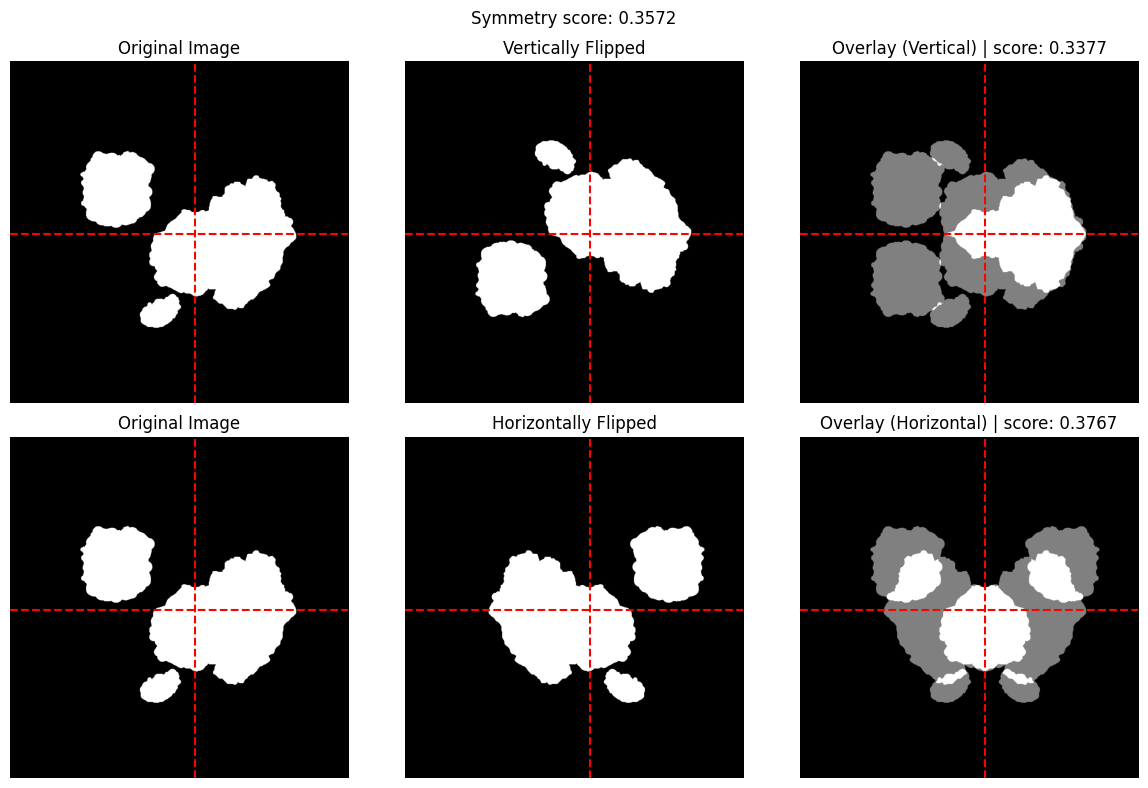

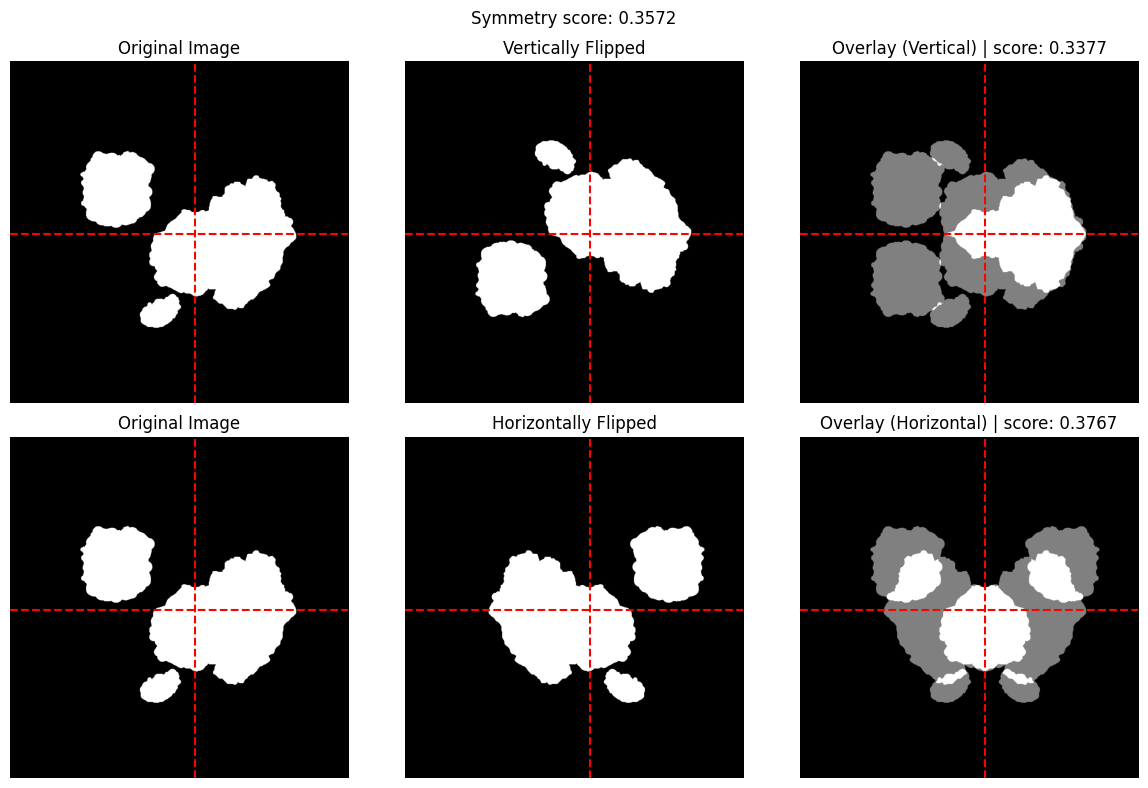

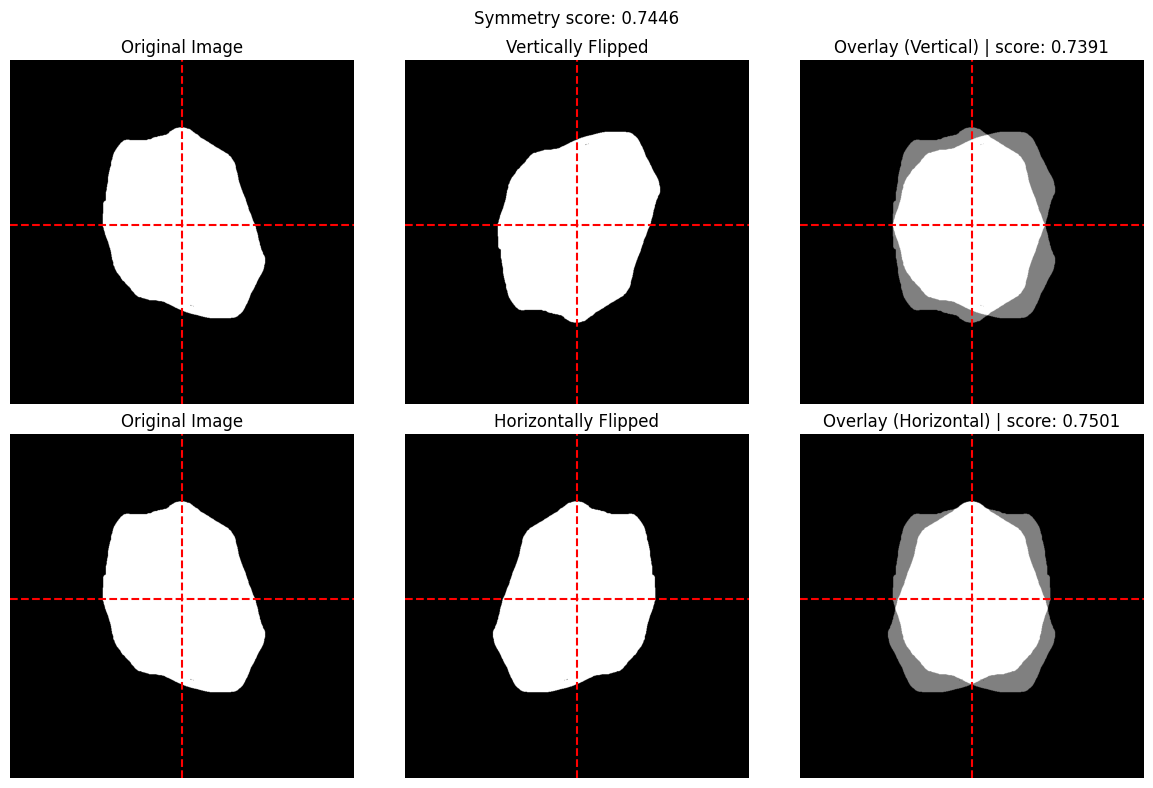

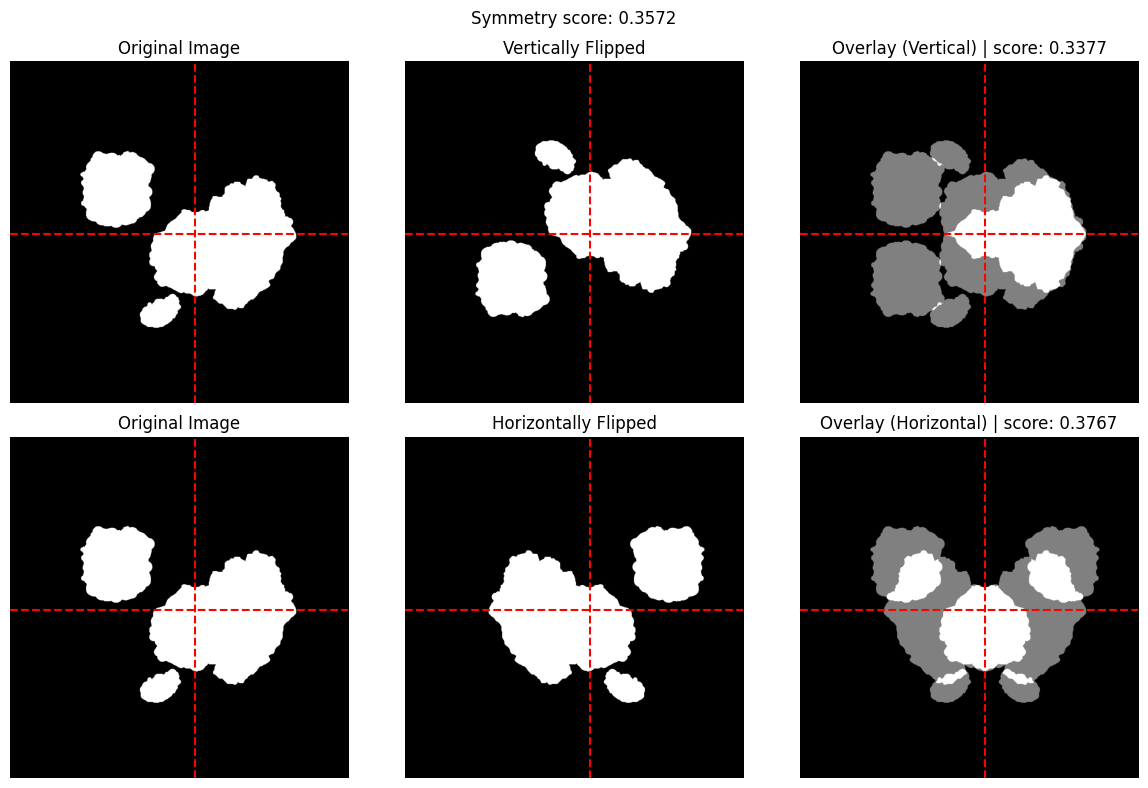

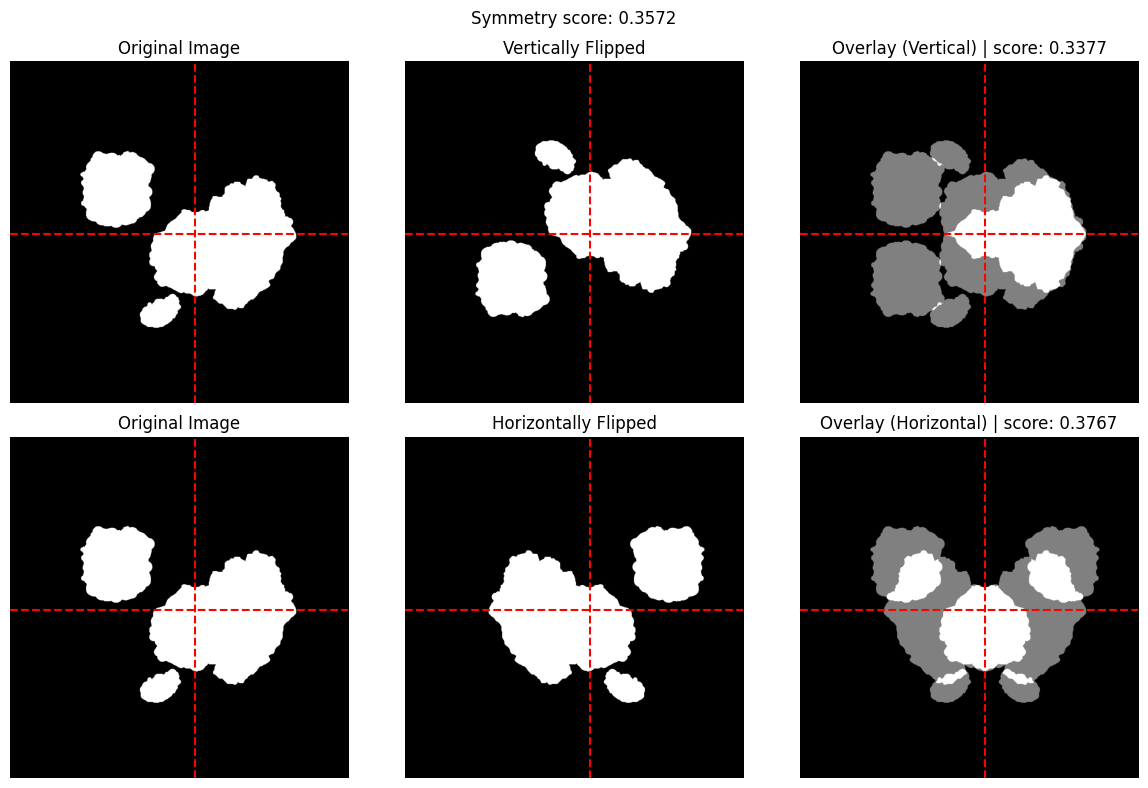

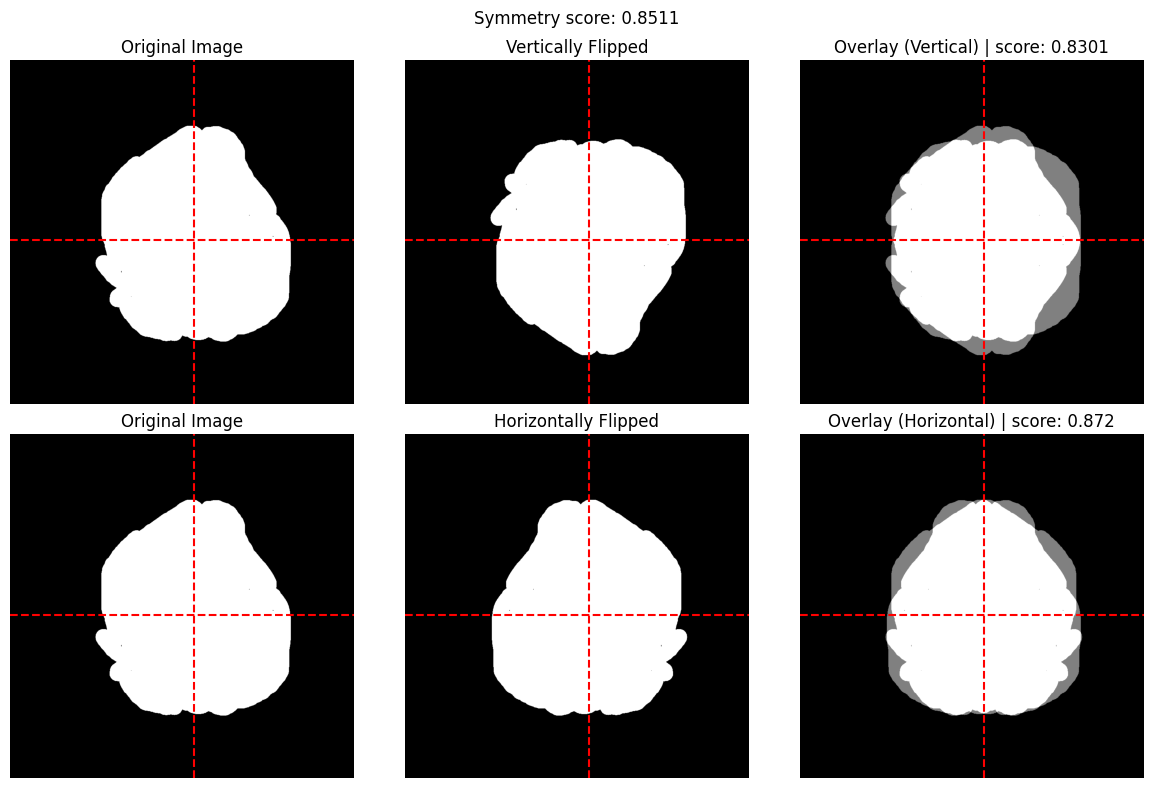

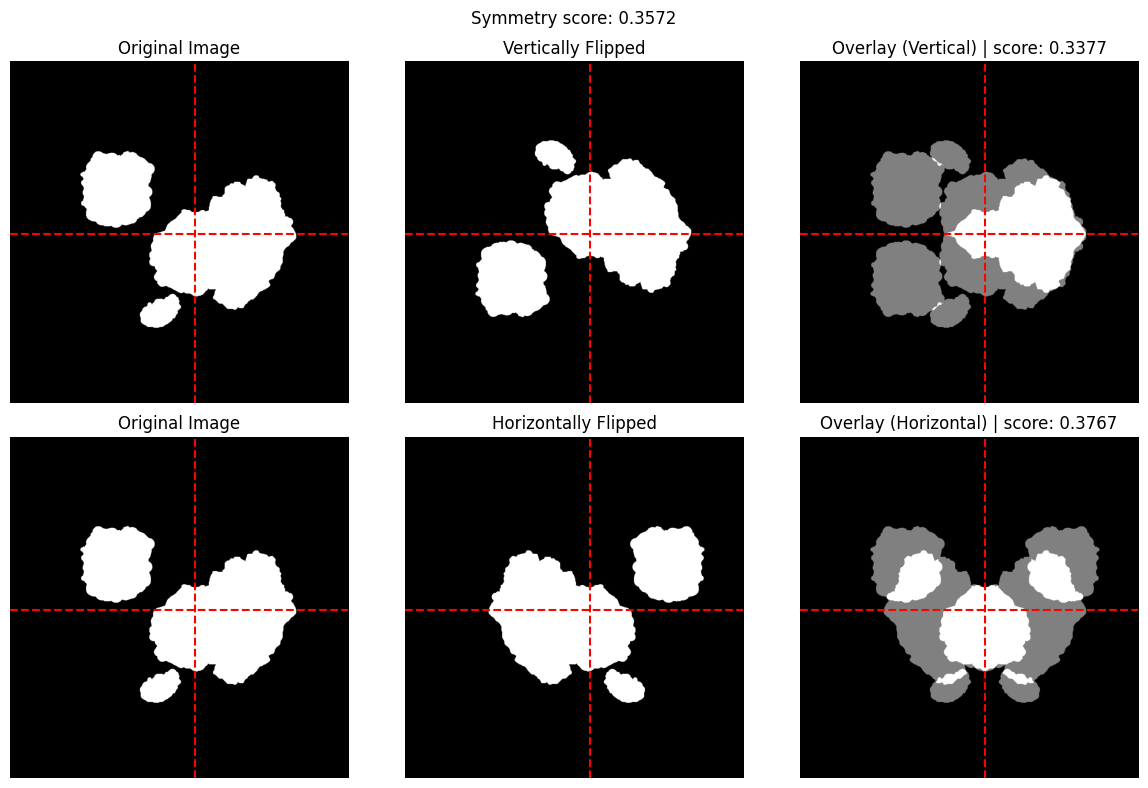

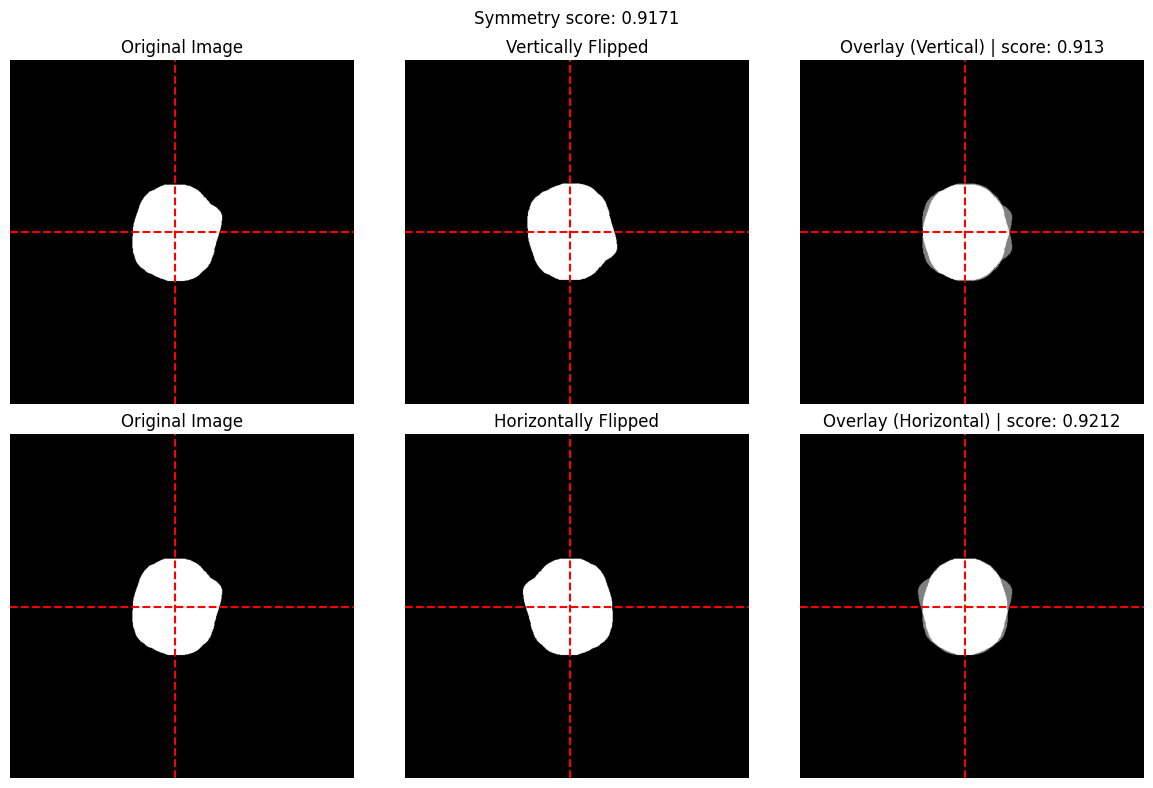

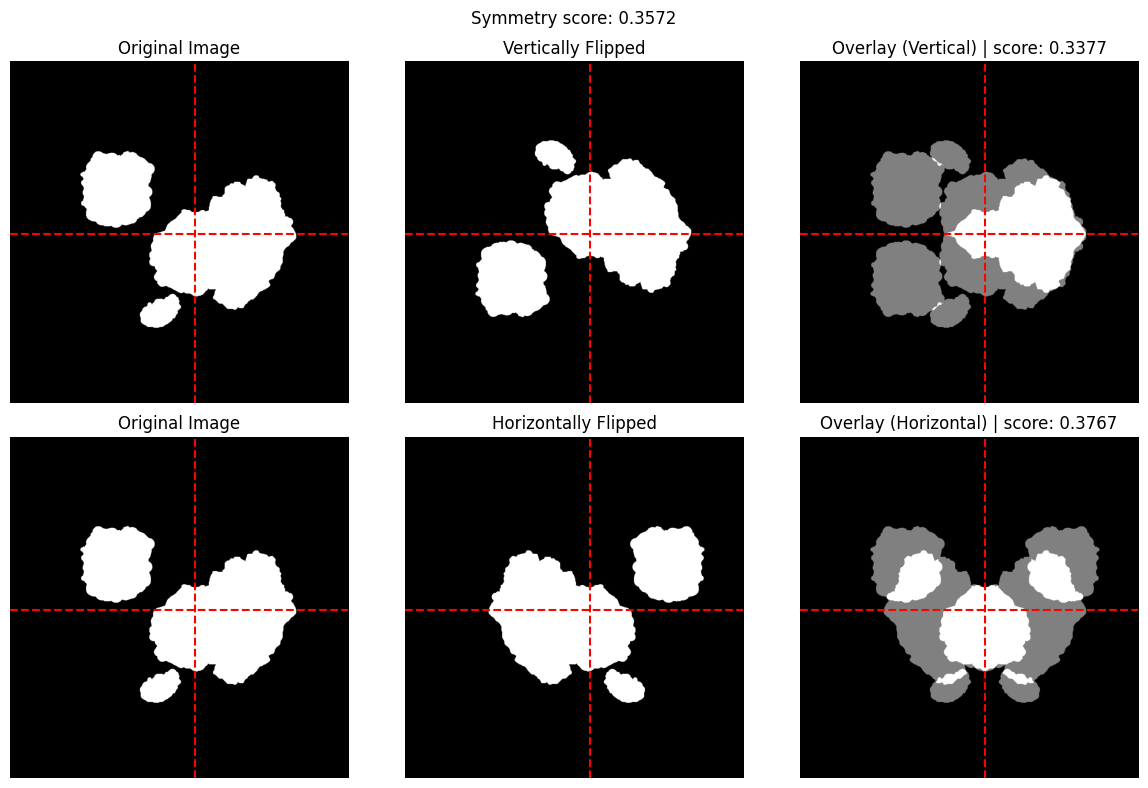

In [81]:
mask_paths = [
    '../good_bad_images/MEL/good/masks/lucie/PAT_340_714_314_mask.png',
    '../good_bad_images/MEL/good/masks/lucie/PAT_995_1867_165_mask.png',
    '../good_bad_images/MEL/good/masks/lucie/PAT_995_1867_165_mask.png',
    '../good_bad_images/MEL/bad/masks/lucie/PAT_262_402_14_mask.png',
    '../good_bad_images/MEL/good/masks/lucie/PAT_995_1867_165_mask.png',
    '../good_bad_images/MEL/good/masks/lucie/PAT_995_1867_165_mask.png',
    '../good_bad_images/NEV/good/masks/PAT_672_1272_705_mask.png',
    '../good_bad_images/MEL/good/masks/lucie/PAT_995_1867_165_mask.png',
    '../good_bad_images/MEL/good/masks/lucie/PAT_995_1867_165_mask.png',
    '../good_bad_images/SCC/bad/masks/david/PAT_131_197_974_mask.png',
    '../good_bad_images/MEL/good/masks/lucie/PAT_995_1867_165_mask.png',
    '../good_bad_images/SEK/good/masks/PAT_893_1697_613_mask.png',
    '../good_bad_images/MEL/good/masks/lucie/PAT_995_1867_165_mask.png',
]

# Loop over the paths and test each image
for msk_path in mask_paths:
    test_images(msk_path, '../fyp2024/testing_features/testing_images/asymmetry')